<a href="https://colab.research.google.com/github/HunterAlpha7/mv1/blob/main/XGBoost%2BRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flood Probability Prediction
### Ensemble: Random Forest + XGBoost
Target: `FloodProbability` (continuous 0–1)
- 70% train | 10% validation | 20% test

In [ ]:
!pip install -q xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline
sns.set(style='whitegrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Research/Flood prediction database/flood.csv")
print(df.shape)
df.head()

(50000, 21)


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


In [ ]:
X = df.drop('FloodProbability', axis=1)
y = df['FloodProbability']

# 70% train → remaining 30% → split into 10% val + 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

print(f"Train: {len(X_train)} | Validation: {len(X_val)} | Test: {len(X_test)}")

Train: 35000 | Validation: 5000 | Test: 10000


In [ ]:
# Fit individual models so we can extract feature importances
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Ensemble (average of the two)
ensemble = VotingRegressor([('rf', rf), ('xgb', xgb)])
ensemble.fit(X_train, y_train)

print("Training completed!")

Training completed!


### Performance on Validation Set

In [ ]:
y_val_pred = ensemble.predict(X_val)

val_mse  = mean_squared_error(y_val, y_val_pred)
val_mae  = mean_absolute_error(y_val, y_val_pred)
val_r2   = r2_score(y_val, y_val_pred)

print(f"Validation RMSE : {np.sqrt(val_mse):.6f}")
print(f"Validation MAE  : {val_mae:.6f}")
print(f"Validation R²   : {val_r2:.6f}")

Validation RMSE : 0.016088
Validation MAE  : 0.012612
Validation R²   : 0.898627


### Performance on Test Set

In [ ]:
y_test_pred = ensemble.predict(X_test)

test_mse  = mean_squared_error(y_test, y_test_pred)
test_mae  = mean_absolute_error(y_test, y_test_pred)
test_r2   = r2_score(y_test, y_test_pred)

print(f"Test RMSE : {np.sqrt(test_mse):.6f}")
print(f"Test MAE  : {test_mae:.6f}")
print(f"Test R²   : {test_r2:.6f}")

Test RMSE : 0.016068
Test MAE  : 0.012544
Test R²   : 0.897223


### Plots

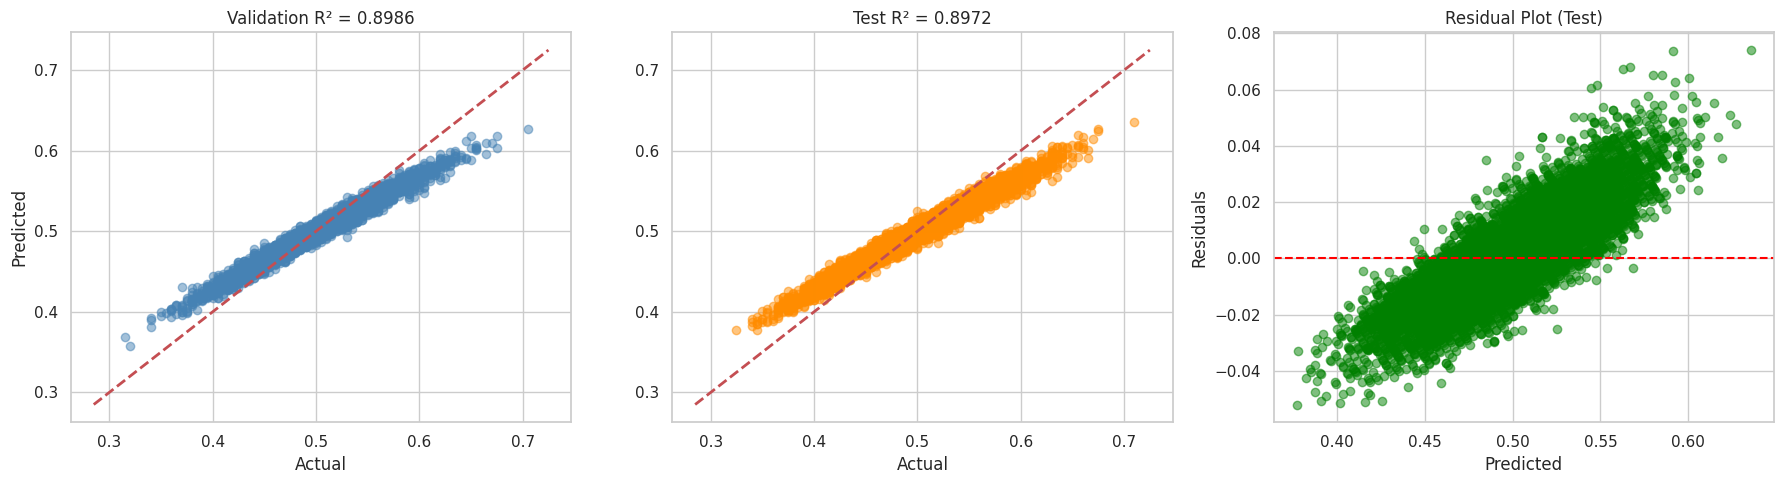

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Validation
ax[0].scatter(y_val, y_val_pred, alpha=0.5, color='steelblue')
ax[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax[0].set_xlabel('Actual')
ax[0].set_ylabel('Predicted')
ax[0].set_title(f'Validation R² = {val_r2:.4f}')

# Test
ax[1].scatter(y_test, y_test_pred, alpha=0.5, color='darkorange')
ax[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax[1].set_xlabel('Actual')
ax[1].set_title(f'Test R² = {test_r2:.4f}')

# Residuals
residuals = y_test - y_test_pred
ax[2].scatter(y_test_pred, residuals, alpha=0.5, color='green')
ax[2].axhline(0, color='red', linestyle='--')
ax[2].set_xlabel('Predicted')
ax[2].set_ylabel('Residuals')
ax[2].set_title('Residual Plot (Test)')

plt.tight_layout()
plt.show()

### Feature Importance (Random Forest)

/tmp/ipython-input-710939199.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feat_names[indices], palette='magma')


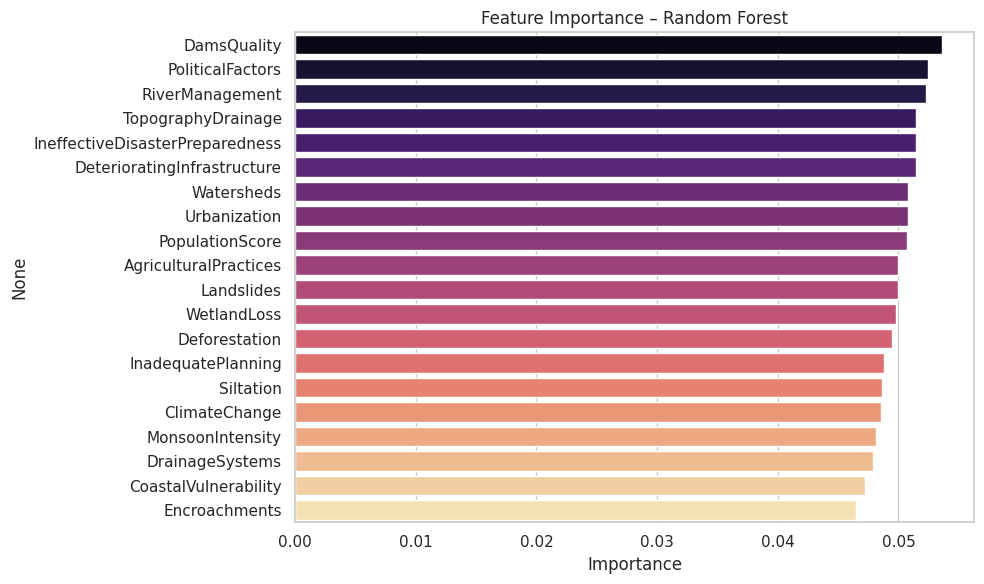

In [ ]:
importances = rf.feature_importances_
feat_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feat_names[indices], palette='magma')
plt.title('Feature Importance – Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()